# OCR research
Optical Character Recognition

Python-tesseract is a python wrapper for Google's Tesseract-OCR <br>
For the intallation : [Link](https://github.com/UB-Mannheim/tesseract/wiki) + `pip install pytesseract`
- Additionnal scrip :
    - add `latin script`
- Additionnal language data :
    - add `english middle (1100-1500)`
    - add `french middle (1400-1600)`
    - add `occitan (post 1500)` <br><br>

In [123]:
import cv2
import json

import pytesseract as OCR
from pytesseract import Output

from difflib import SequenceMatcher
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
import os


In [154]:
# To let connect to the app Tessdata
OCR.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
os.environ["TESSDATA_PREFIX"] = r"C:/Program Files/Tesseract-OCR/tessdata" # Leaving it empty because file is already copy pasted in the current directory
print(os.getenv("TESSDATA_PREFIX"))

C:/Program Files/Tesseract-OCR/tessdata


# Configuratin

In [92]:
def Image(name : str):
    img = cv2.imread(r'.\\image\\' + name)
    if img is None:
        Print("Image Not Found")
    return img

def config(psm=1, oem=1):
    return rf'--psm {psm} --oem {oem}'

def Print(img, name = "img"):
    # Convert BGR to RGB and print it
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(name)
    plt.show()

def Score(original : str, transcrip : str):
    return SequenceMatcher(None, original, transcrip).ratio()

In [167]:
def Transcription(img, lang=None, myconfig = ''):
    try:
        transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
    except Exception as e:
        transciption = ""
        traceback.print_exc()
        print("\n")
    return transciption

In [57]:
def Charac(img, lang= 'eng', myconfig= config()):
    # Get the boxes of the recognize letter
    img_copy = img.copy()
    data = OCR.image_to_boxes(image=img_copy, lang=lang, config=myconfig)
    # don't accepte  output_type='data.frame' for some reason
    
    # Draw green box arround
    height = img_copy.shape[0]   # cv2.shape : height, width, channel ~= color
    for box in data.splitlines():
        box = box.split(" ")
        img_copy = cv2.rectangle(
            img=img_copy, 
            pt1=(int(box[1]), height - int(box[2])),
            pt2=(int(box[3]), height - int(box[4])),
            color=(0, 255, 0) # BGR color system
        )
    
    Print(img_copy, "Recognize character")

In [59]:
def Word(img, myconfig = config(), trust_limit = 80.0, draw_text=False):
    # Extract data and take only the trusted word
    img_copy = img.copy()
    data = OCR.image_to_data(image=img_copy, config=myconfig, output_type=Output.DATAFRAME)
    trust_data = data[ data['conf'] > trust_limit ]    # only with confidence above trust limit (80%)

    
    for _, row in trust_data.iterrows():
        (x, y, width, height) = (row['left'], row['top'], row['width'], row['height'])
        
        # Draw red box arround
        img_copy= cv2.rectangle(
            img= img_copy,
            pt1= (x,y),
            pt2= (x+width, y+height),
            color= (0,0,255)    #BGR system
        )
        
        # Write red text bellow
        if draw_text:
            img_copy = cv2.putText(
                img= img_copy,
                text= row["text"],
                org= (x, y+height+5),
                fontFace= cv2.FONT_HERSHEY_COMPLEX_SMALL,
                fontScale= 0.5,
                color= (0,0,255)
            )
    
    Print(img_copy, "Recognize word")

In [7]:
with open(r'.\\text.json', 'r', encoding='utf-8') as file:
    original = json.load(file)

# Calibration

In [8]:
img = Image("OCR_eng.png")
original_txt = original["OCR"]["eng"]

In [65]:
myconfig = config(1,1)
print(myconfig)
OCR.image_to_string(img, config=myconfig)

--psm 1 --oem 1


'English texts for beginners to practice reading and comprehension online and for free. Practicing\nyour comprehension of written English will both improve your vocabulary and understanding of\ngrammar and word order. The texts below are designed to help you develop while giving you an\n\ninstant evaluation of your progress.\n'

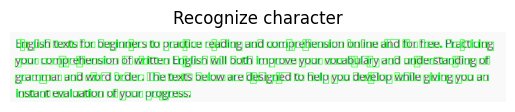

In [58]:
Charac(img)

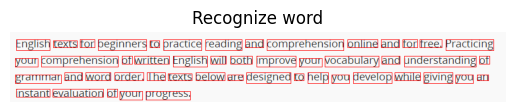

In [180]:
Word(img)

In [105]:
img = Image("OCR_eng.png")
transciption = OCR.image_to_string(
    image=img, 
    lang='eng',
    config=r'--psm 1 --oem 3'
)
Score(original_txt, transciption)

0.9875389408099688

In [174]:
output = OCR.image_to_string(
    image=img,
    #lang='yhdtflat', 
    config=myconfig
)
print(output)
print(myconfig)

Sans eee

--psm 13 --oem 3


In [176]:
transcrip= np.empty((14, 4), dtype=np.dtype('U'))   # the output of the OCR
score= np.empty((14, 4))       # the score of this output

# For each possibility
for psm in range(0,14):
    for oem in range(0,4):
        # Score the result
        myconfig = config(psm, oem)
        transcrip[psm,oem] = Transcription(img, myconfig=myconfig)
        score[psm,oem] = Score(original_txt, transcrip[psm,oem])

# Print best parameter
psm_max, oem_max = np.unravel_index(np.argmax(score), score.shape)
score_max = score[psm_max, oem_max]
print(f'Best parameter: psm {psm_max}\toem {oem_max}\nAssociate Score: {score_max}')

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 290, in run_and_get_output
    with open(filename, 'rb') as output_file:
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\User

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 290, in run_and_get_output
    with open(filename, 'rb') as output_file:
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\User

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 290, in run_and_get_output
    with open(filename, 'rb') as output_file:
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\User

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 290, in run_and_get_output
    with open(filename, 'rb') as output_file:
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\User

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_10220\377098847.py", line 3, in Transcription
    transciption = OCR.image_to_string(image=img, lang=lang, config=myconfig)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 423, in image_to_string
    return {
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 426, in <lambda>
    Output.STRING: lambda: run_and_get_output(*args),
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytesseract\pytesseract.py", line 288, in run_and_get_output
    run_tesseract(**kwargs)
  File "C:\Users\ruben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_



Best parameter: psm 1	oem 1
Associate Score: 0.006230529595015576


Text(0.5, 1.0, 'Best Config: psm 1 oem 1')

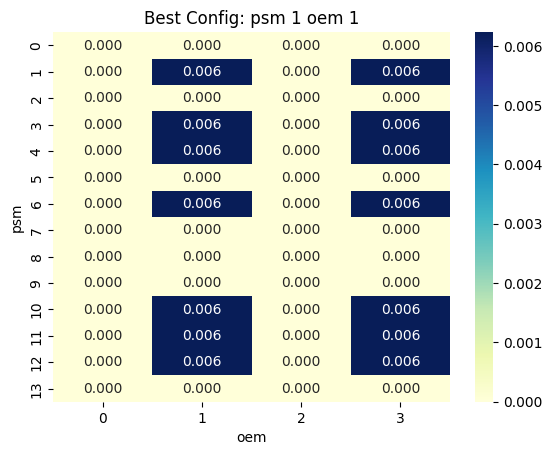

In [159]:
# Print the best config round 3 decimales
sns.heatmap(score, cmap="YlGnBu", annot=True, fmt=".3f")
plt.ylabel("psm")
plt.xlabel("oem")
plt.title(f"Best Config: psm {psm_max} oem {oem_max}")

In [179]:
for i in range(transcrip.shape[0]):
    for j in range(transcrip.shape[1]):
        print(f"psm,eom : {(i,j)}\tScore: {round(score[i,j], 3)}\tTranscrip: {transcrip[i,j]}")

psm,eom : (0, 0)	Score: 0.0	Transcrip: 
psm,eom : (0, 1)	Score: 0.0	Transcrip: 
psm,eom : (0, 2)	Score: 0.0	Transcrip: 
psm,eom : (0, 3)	Score: 0.0	Transcrip: 
psm,eom : (1, 0)	Score: 0.0	Transcrip: 
psm,eom : (1, 1)	Score: 0.006	Transcrip: E
psm,eom : (1, 2)	Score: 0.0	Transcrip: 
psm,eom : (1, 3)	Score: 0.006	Transcrip: E
psm,eom : (2, 0)	Score: 0.0	Transcrip: 
psm,eom : (2, 1)	Score: 0.0	Transcrip: 
psm,eom : (2, 2)	Score: 0.0	Transcrip: 
psm,eom : (2, 3)	Score: 0.0	Transcrip: 
psm,eom : (3, 0)	Score: 0.0	Transcrip: 
psm,eom : (3, 1)	Score: 0.006	Transcrip: E
psm,eom : (3, 2)	Score: 0.0	Transcrip: 
psm,eom : (3, 3)	Score: 0.006	Transcrip: E
psm,eom : (4, 0)	Score: 0.0	Transcrip: 
psm,eom : (4, 1)	Score: 0.006	Transcrip: E
psm,eom : (4, 2)	Score: 0.0	Transcrip: 
psm,eom : (4, 3)	Score: 0.006	Transcrip: E
psm,eom : (5, 0)	Score: 0.0	Transcrip: 
psm,eom : (5, 1)	Score: 0.0	Transcrip: 2
psm,eom : (5, 2)	Score: 0.0	Transcrip: 
psm,eom : (5, 3)	Score: 0.0	Transcrip: 2
psm,eom : (6, 0)	Sco